In [307]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [308]:
data_folder = Path('../../data')
figure_folder = Path('../../Figures/')

In [309]:
intra_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4B_intracellular_conc_nmol_per_gprotein.csv'
extra_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4A_extracellular_conc_uM.csv'
live_dead_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4C_live_dead_results.csv'
od_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4D_sampling_OD.csv'

In [310]:
intra_df = pd.read_csv(intra_fn, index_col=0)
extra_df = pd.read_csv(extra_fn, index_col=0)
ld_df = pd.read_csv(live_dead_fn, index_col=0)

In [311]:
extra_df['Sample_id'] = extra_df['Sample_id'].str[:-7]

In [312]:
intra_df['Sample_id'] = intra_df['Sample_id'].str.replace('_', '-')

In [313]:
df_od = pd.read_csv(od_fn, index_col=0)

In [314]:
ld_df = ld_df.loc[ld_df.Dilution=='1X']

In [315]:
# Convert intracellular concentrations to total amount based on OD and conversion factors

# Get T4-T1 delta

In [316]:
extra_df_t1 = extra_df.loc[extra_df.Timepoint == 'T1']
extra_df_t4 = extra_df.loc[extra_df.Timepoint == 'T4']


In [317]:
metabolites = sorted(['Leucine',
       'Glutamate', 'Aspartate', 'Fructose-6-phosphate', 'Cis-aconitate'])
carbon_sources = ['Galactose', 'L-malate', 'L-alanine']

In [342]:
dfs = []
for m in metabolites:
    for cs in carbon_sources:
        t1_idx = (extra_df.Timepoint=='T1')&(extra_df['Carbon source']==cs)
        t4_idx = (extra_df.Timepoint=='T4')&(extra_df['Carbon source']==cs)
        t1_data = extra_df.loc[t1_idx, [m, 'Sample #']]
        t4_data = extra_df.loc[t4_idx, [m, 'Sample #']]

        # Discard data that has too few replicate values
        if t4_data[m].isna().sum() == len(t4_data):
            # All nan values at T4 - skip
            continue
        # elif t4_data[m].notna().sum()+t1_data[m].notna().sum()<3:
        #     continue
        
        # fill nan values in T1 data
        if t1_data[m].isna().sum() == len(t1_data):
            t1_data[m] = 0
        elif t1_data[m].isna().sum() > 0:
            t1_data[m].fillna(t1_data[m].mean())
            
        temp = pd.merge(left = t1_data, right=t4_data, left_on='Sample #', right_on='Sample #', suffixes=['-T1', '-T4'])
        temp['Δ concentration [uM]'] = temp[f'{m}-T4']-temp[f'{m}-T1']
        # temp['Carbon source'] = cs
        temp['Metabolite'] = m
        dfs.append(temp[['Sample #', 'Metabolite', 'Δ concentration [uM]']])#'Carbon source'


In [343]:
delta_ex = pd.concat(dfs)

In [344]:
delta_ex.loc[delta_ex['Δ concentration [uM]']<0, 'Δ concentration [uM]'] = np.nan

# Using OD as cell concentration measure

In [345]:
sample_id_to_od = df_od.set_index('Common sample ID')['OD at sampling'].to_dict()

In [346]:
intra_df['OD'] = intra_df.Sample_id.map(sample_id_to_od)


In [347]:
protein_density = 13.5*1e-8#  μg/μm^3 From Mori et al., 2017 (See SI) https://www.nature.com/articles/s41467-017-01242-8
# Protein density seems to be not correlated with growth rate

cubic_um_to_L = 1e-15 # L/um^3
protein_denisty_g_per_L = protein_density/cubic_um_to_L*1e-6

In [348]:
id_vars = ['Sample_id', 'Sample #', 'Carbon source', 'Timepoint', 'OD']
df_intraL = intra_df.melt(id_vars=id_vars, var_name='Metabolite', value_name='Concentration [nmol/g protein]')

In [349]:
df_intraL['Concentration [uM]'] = df_intraL['Concentration [nmol/g protein]']*protein_denisty_g_per_L*1e-3

In [350]:
total_cell_volume_per_od = 3.6 # uL per OD per mL Total cell volume conversion, see Volkmer and Heinemann 2011, https://pmc.ncbi.nlm.nih.gov/articles/PMC3146540/


In [351]:
# df_intraL['Corresponding E. concentration [mM]'] = df_intraL['Concentration [uM]']*total_cell_volume_per_od*df_intraL['OD']


In [352]:

df_intraL['Corresponding Ex. concentration [uM]'] = total_cell_volume_per_od*df_intraL['OD']*1e-6*df_intraL['Concentration [uM]']*1e3


In [353]:
df_death = df_intraL.merge(right=delta_ex, left_on=('Sample #', 'Metabolite'), right_on = ('Sample #', 'Metabolite'))

# Get dead fraction

In [354]:
ld_df['Sample #'] = ld_df.Sample_id.str[:2]

In [355]:
sample_to_dead_fraction = ld_df.loc[ld_df['Live/Dead']=='Live'].set_index('Sample #')['Dead fraction'].to_dict()

In [356]:
sample_to_dead_fraction

{'1A': 0.0022171887794224,
 '1B': 0.0236893152868333,
 '1C': 0.0023303582119796,
 '1D': 0.0031019757629409,
 '2A': 0.0075280044724333,
 '2B': 0.0076061408152461,
 '2C': 0.0067909055763592,
 '2D': 0.0059630171381029,
 '3A': 0.0022953767287055,
 '3B': 0.0020330137152567,
 '3C': 0.0037972866380275,
 '3D': 0.002241516749771}

In [357]:
df_death['Dead fraction'] = df_death['Sample #'].map(sample_to_dead_fraction)

In [358]:
df_death['Fraction explained'] = df_death['Corresponding Ex. concentration [uM]']*df_death['Dead fraction']/df_death['Δ concentration [uM]']

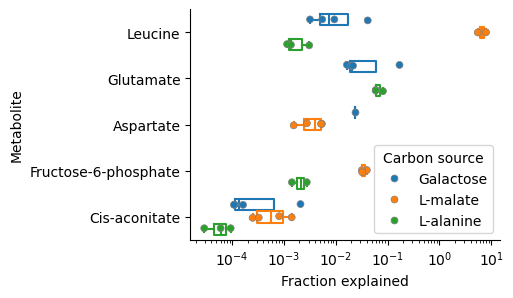

In [377]:
fig, ax = plt.subplots(1, figsize = (4,3))
l = sns.boxplot(df_death, x = 'Fraction explained', hue = 'Carbon source', y = 'Metabolite', fill = False,gap=.1,
                ax = ax, legend = None, fliersize = 0)#color = 'w', , linecolor = 'grey'
sns.stripplot(df_death, x = 'Fraction explained', hue = 'Carbon source', y = 'Metabolite', dodge=True, ax = ax,
             edgecolor = 'grey', linewidth = 0.5)# sns.move_legend()
ax.set_xscale('log')
sns.despine()
fig_fn = figure_folder / '2_paired_death_1.pdf'
plt.savefig(fig_fn)

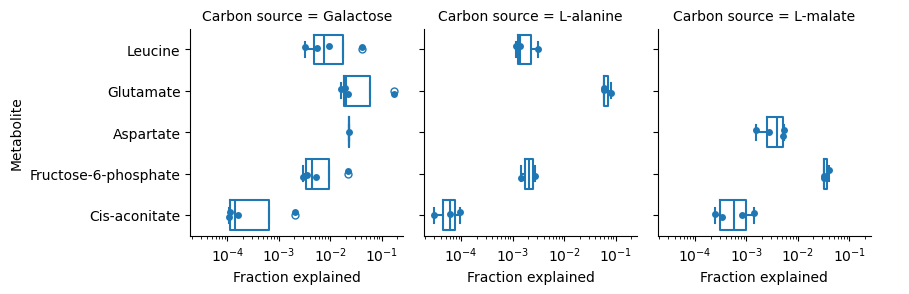

In [306]:
g = sns.catplot(df_death, x = 'Fraction explained', col = 'Carbon source', y = 'Metabolite', fill = False,gap=.1, kind ='box', height=3)
g.map_dataframe(sns.stripplot, data = df_death, x = 'Fraction explained', y = 'Metabolite', dodge=True)
for ax in g.axes[0]:
    ax.set_xscale('log')
sns.despine()
fig_fn = figure_folder / '2_paired_death_3.pdf'
plt.savefig(fig_fn)

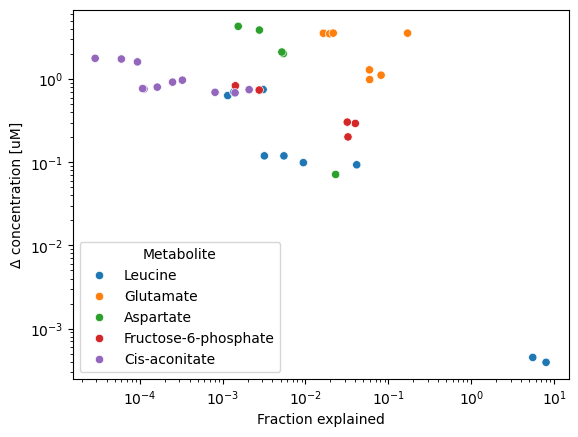

In [365]:
ax = sns.scatterplot(df_death, x = 'Fraction explained', y = 'Δ concentration [uM]', hue = 'Metabolite',
)

ax.set_yscale('log')
ax.set_xscale('log')

# Fraction explained if all cells are lysed

In [336]:
df_death['Fraction explained all cells lysed'] = df_death['Corresponding Ex. concentration [uM]']/df_death['Δ concentration [uM]']

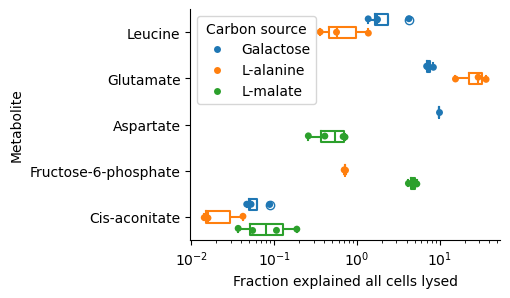

In [340]:
fig, ax = plt.subplots(1, figsize = (4,3))
l = sns.boxplot(df_death, x = 'Fraction explained all cells lysed', hue = 'Carbon source', y = 'Metabolite', fill = False,gap=.1,
                ax = ax, legend = None)
sns.stripplot(df_death, x = 'Fraction explained all cells lysed', hue = 'Carbon source', y = 'Metabolite', dodge=True, ax = ax)
ax.set_xscale('log')
sns.despine()
